## Import necessary libraries

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import torch
import cv2 as cv
import json
import torchvision.transforms
from controlnet_aux import OpenposeDetector

/Users/jamesmoore/Desktop/6.8301/CV-Project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jamesmoore/Desktop/6.8301/CV-Project/venv/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


## Read in Datasheet with references to images

In [31]:
df = pd.read_csv('FracAtlas/dataset.csv')

## Show example images

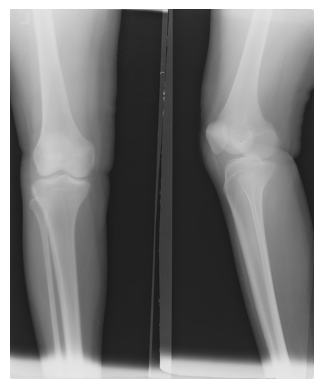

In [32]:
num_fracs = 0 #only show one example for each
num_non_fracs = 0
multi = 0


for index, row in df.iterrows():
    image_id = row['image_id']
    fractured_indicator = row['fractured']
    multi_indicator = row['multiscan']
    if fractured_indicator and multi_indicator:
        filename = f'FracAtlas/images/Fractured/{image_id}'
    else:
        filename = f'FracAtlas/images/Non_fractured/{image_id}'

    if num_fracs == 0 and fractured_indicator and multi == 0:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_fracs += 1
        multi += 1
    
    if num_non_fracs == 0 and not fractured_indicator and multi == 0:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_non_fracs += 1
        multi += 1

## Transform skeletal images to controlmaps to feed into controlnet and image generation
These controlmaps will be done using the process of image segmentation, generating an image that is easily reproducible by hand to feed into the controlnet and subsequent x-ray image generation.

In [33]:
ex = df.loc[14]
image_id = ex['image_id']
fractured_indicator = ex['fractured']
print("This x-ray is of the ", ex[''])
if fractured_indicator:
    filename = f'FracAtlas/images/Fractured/{image_id}'
else:
    filename = f'FracAtlas/images/Non_fractured/{image_id}'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=(10, 5))  # Set the figure size as needed

# Display the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Image with red Boundaries')

# Display the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(markers)
plt.axis('off')
plt.title('Segmented Image')

# Show the plot
plt.show()


KeyError: ''

## Smooth edges of controlmaps
First attempt using blurring techniques to decrease granularity of controlmaps, kernel size can be adjusted accordingly

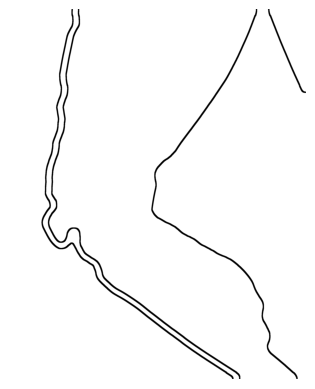

In [ ]:
if markers.ndim == 2 or (markers.ndim == 3 and markers.shape[2] == 1):
    gray_img = markers  # It is already grayscale
else:
    gray_img = cv.cvtColor(markers, cv.COLOR_BGR2GRAY)

# Apply the blur
smoothed_gray_img = cv.blur(gray_img, (100, 100))

# Ensure the image is 8-bit
smoothed_gray_img = cv.convertScaleAbs(smoothed_gray_img)

v = np.median(smoothed_gray_img)

sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(smoothed_gray_img, lower, upper)

kernel = np.ones((10,10), np.uint8)  # Create a 3x3 matrix of ones
dilated_edges = cv.dilate(edges, kernel, iterations=1)

sketch = cv.bitwise_not(dilated_edges);

# Display the dilated edges
plt.imshow(sketch, cmap='gray')
plt.axis('off')
plt.show()

Going to first do tests on leg images since they are simpler to generate and the dataset has the most of it for any body part category. 2009 total non-fractured and 263 fractured images. Should filter out multiscans and limit fracture count to one with the associated label too. Frontal scans only for normalization purposes

Ended up going with leg x-rays from the frontal position as they are the most available type of x-ray with consistent poses that would be good for generating images. At this point I'm excluding x-rays with both the leg and hip since it poses extra complex x-ray generation (hips are complex)

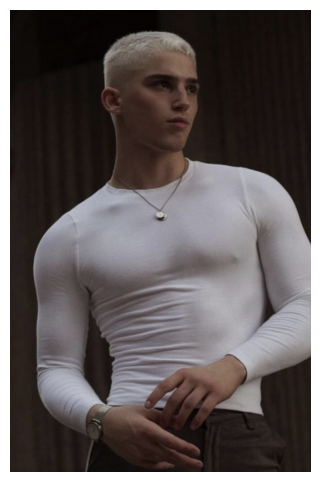

Loading pipeline components...: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


AssertionError: Torch not compiled with CUDA enabled

In [54]:
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

def generate_pose_image(filename, save=False, save_path='pose_output.png'):
    """
    Generates a pose image from a given filename using OpenposeDetector.
    
    Args:
    filename (str): Path to the image file.
    save (bool): Whether to save the output image to disk.
    save_path (str): Path where the output image should be saved, if save is True.
    
    Returns:
    PIL.Image.Image: The pose image generated by OpenposeDetector.
    """
    # Load image
    img = Image.open(filename)

    # Optionally display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Initialize the OpenposeDetector
    openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
    
    # Process the image to generate pose
    pose_image = openpose(img)

    controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16
    )

    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
    )

    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

    # Remove if you do not have xformers installed
    # see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
    # for installation instructions
    #pipe.enable_xformers_memory_efficient_attention()

    pipe.enable_model_cpu_offload()

    output_image = pipe("chef in the kitchen", pose_image, num_inference_steps=20).images[0]
    
    # Check if the image needs to be saved
    if save:
        # Save the pose image to the specified path
        pose_image.save(save_path)
        print(f"Pose image saved to {save_path}")
    
    # Optionally display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()
    
    return pose_image

# Example usage
pose_img = generate_pose_image('example.png', save=False, save_path='generated_pose_image.png')
#pose_img = generate_pose_image('FracAtlas/images/Fractured/IMG0000025.jpg', save=False, save_path='generated_pose_image.png')

HERE


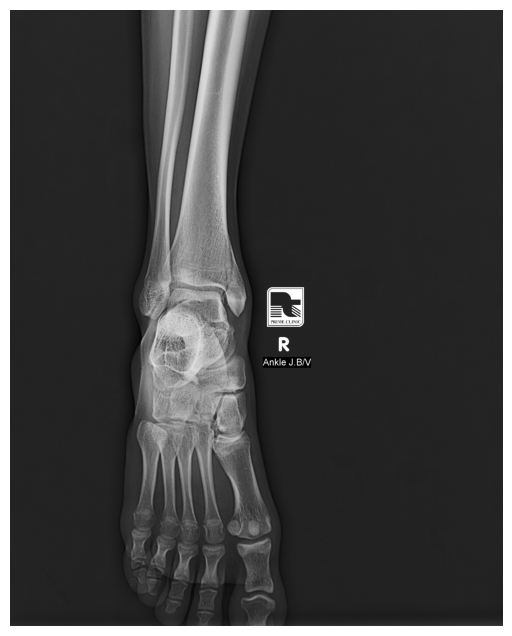

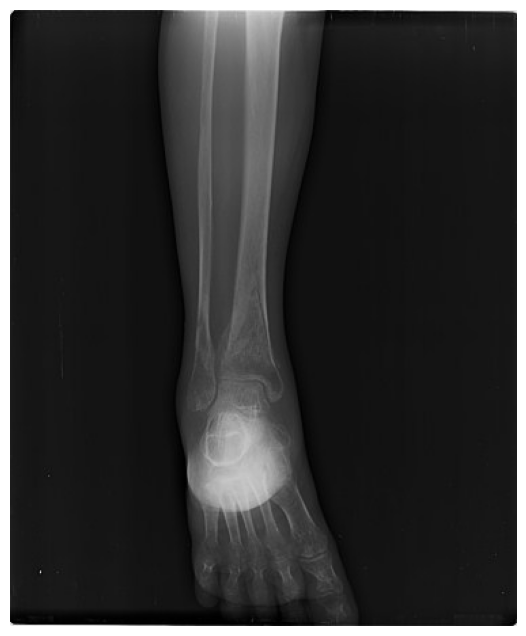

TOTAL 2
TOTAL FRACS 2
TOTAL NON FRACS 0


In [5]:
import cv2
import pandas as pd
import json
import matplotlib.pyplot as plt

# Function to add a translucent box on the image
def add_translucent_box(image, bbox):
    # Extract the coordinates and dimensions of the bbox
    x, y, width, height = bbox
    x, y, width, height = int(x), int(y), int(width), int(height)

    # Create a rectangle overlay with transparency
    overlay = image.copy()
    cv2.rectangle(overlay, (x, y), (x+width, y+height), (255, 0, 0), -1)  # Red rectangle with full opacity

    # Apply the overlay. 0.3 is the transparency factor
    image_new = cv2.addWeighted(overlay, 0.3, image, 0.7, 0)

    return image_new

# Load your CSV file into a DataFrame
df = pd.read_csv('FracAtlas/dataset.csv')

# Filter the DataFrame
filtered_df = df[(df['leg'] == 1) & (df['hip'] == 0) & (df['multiscan'] == 0) & (df['frontal'] == 1) & (df['hardware'] == 0)]

# Load and parse the COCO JSON file
with open(r'FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json', 'r') as file:  # Update the path to your JSON file
    data = json.load(file)

# Directory where the images are stored (update this path as necessary)
image_directory = 'FracAtlas/images/Fractured/'

# Process each image based on the annotations
count = 0
fracs = 0
imgs = []
for annotation in data['annotations']:
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    segmentation = annotation['segmentation']
    
    # Find the corresponding image file
    image_info = next((item for item in data['images'] if item['id'] == image_id), None)
    if image_info:
        # Get all rows that match the file_name
        matches_df = filtered_df[filtered_df['image_id'] == image_info['file_name']]

        # Check if there are any matches
        if not matches_df.empty:
            corresponding_row = matches_df.iloc[0]  # Safely get the first row
            
            file_name = image_directory + image_info['file_name']
                    
            # Load the image
            img = cv2.imread(file_name, cv2.IMREAD_COLOR)
            if img is not None:
                # for seg in segmentation:
                #     pts = np.array(seg, np.int32).reshape((-1, 1, 2))
                #     cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)  # Red color

                # Show the image using Matplotlib
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()

                if corresponding_row['fractured']: fracs += 1
                count += 1
            else:
                print(f"Image {file_name} not found.")
            if count > 1:
                break

This is an experimental model for taking x-rays and turning them into pose maps

First we'll generate some ground truth and annotated pairs for training. We manually annotate some pictures using Makesense.ai which returns a csv file containing the annotations. This code takes those annotations and creates pose maps from it and then saves it to a local folder.

In [22]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Load the CSV files
points_df = pd.read_csv('point_annotations.csv', header=None, names=['id', 'x', 'y', 'filename', 'width', 'height'])
lines_df = pd.read_csv('line_annotations.csv', header=None, names=['id', 'x1', 'y1', 'x2', 'y2', 'filename', 'width', 'height'])

# Normalize keypoint coordinates relative to image dimensions
points_df['x'] /= points_df['width']
points_df['y'] /= points_df['height']
lines_df['x1'] /= lines_df['width']
lines_df['y1'] /= lines_df['height']
lines_df['x2'] /= lines_df['width']
lines_df['y2'] /= lines_df['height']

# Consolidate all filenames from points and lines for image processing
all_filenames = pd.concat([points_df['filename'], lines_df['filename']]).unique()

# Image processing and resizing parameters
target_size = (256, 256)  # Define a consistent target size for all images

# Create directories for saving images if not exist
os.makedirs('processed_images', exist_ok=True)
os.makedirs('pose_maps', exist_ok=True)

# Create a color map for points and lines based on unique IDs
unique_ids = np.unique(points_df['id'].tolist() + lines_df['id'].tolist())
colors = plt.cm.get_cmap('tab20', len(unique_ids))
color_map = dict(zip(unique_ids, colors(range(len(unique_ids)))))

# Process images and generate pose maps
for filename in all_filenames:
    image_path = f'annotated_images/{filename}'
    processed_path = f'processed_images/{filename}'
    pose_map_path = f'pose_maps/{filename.replace(".jpg", "_pose.jpg")}'  # Ensure unique pose map filename

    try:
        # Open and process the original image
        with Image.open(image_path) as img:
            processed_img = img.convert('L').resize(target_size, Image.Resampling.LANCZOS)
            processed_img.save(processed_path)  # Save the processed original image

        # Create and save pose map images
        fig, ax = plt.subplots()
        # Set the size of the figure to match the target size
        fig.set_size_inches(target_size[0] / fig.dpi, target_size[1] / fig.dpi)
        # Create a blank plot with a black background
        ax.set_facecolor('black')  # Ensure the plotting background is black
        fig.set_facecolor('black')  # Optionally set the figure background too
        ax.axis('off')
        ax.set_frame_on(False)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        if filename in lines_df['filename'].values:
            lines_group = lines_df[lines_df['filename'] == filename]
            for index, row in lines_group.iterrows():
                ax.plot([row['x1'], row['x2']], [1 - row['y1'], 1 - row['y2']], '-', color=color_map[row['id']], linewidth=2)  # Invert y-coordinates

        points_group = points_df[points_df['filename'] == filename]
        for index, row in points_group.iterrows():
            ax.plot(row['x'], 1 - row['y'], 'o', color=color_map[row['id']], markersize=5)  # Invert y-coordinate here

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.savefig(pose_map_path, dpi=fig.dpi, bbox_inches='tight', pad_inches=0)
        plt.close()

    except FileNotFoundError:
        print(f"File not found: {image_path}")

# Example of splitting dataset
image_pairs = list(zip([f'processed_images/{f}' for f in all_filenames], [f'pose_maps/{f.replace(".jpg", "_pose.jpg")}' for f in all_filenames]))
train_files, test_files = train_test_split(image_pairs, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# Now you have train_files, val_files, test_files, which are tuples of (original_image_path, pose_map_path)


/var/folders/t1/_cmlbqc525vfqssvctbpxgwm0000gn/T/ipykernel_45237/531075290.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_ids))


Next we can load the images we just created into a dataloader for training

In [27]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch

class PoseDataset(Dataset):
    def __init__(self, image_pairs, transform=None):
        """
        image_pairs: List of tuples [(xray_image_path, pose_map_path), ...]
        transform: torchvision.transforms for input preprocessing
        """
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        xray_path, pose_path = self.image_pairs[idx]

        xray_image = Image.open(xray_path).convert('L')
        pose_image = Image.open(pose_path).convert('RGB')

        if self.transform:
            xray_image = self.transform(xray_image)
            pose_image = self.transform(pose_image)

        return xray_image, pose_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create DataLoaders
train_dataset = PoseDataset(train_files, transform=transform)
val_dataset = PoseDataset(val_files, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


Then we need to instantiate our model class which defines the different layers for the model.

In [28]:
import torch
import torch.nn as nn
from torchvision.models import vgg19

class CustomOpenPose(nn.Module):
    def __init__(self, num_keypoints):
        super(CustomOpenPose, self).__init__()
        # Load a pre-trained VGG19 model to use as the feature extractor
        vgg_model = vgg19(pretrained=True)

        # Modify the first layer to accept 1 channel input instead of 3
        self.features = vgg_model.features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

        # Use the features from VGG19 and add custom layers for pose estimation
        # Reconstruct the features to ensure it is trainable
        self.features = nn.Sequential(*list(self.features.children()))

        # Additional layers for pose estimation, adjusting from 512 feature maps to the number of keypoints
        self.pose_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_keypoints * 2, kernel_size=1)  # Each keypoint has x and y coordinates
        )

    def forward(self, x):
        x = self.features(x)  # Pass the input through the feature layers
        x = self.pose_layers(x)  # Pass the result through the pose estimation layers
        return x


Then we can specify the different hyperparameters for training and then we can train the model

In [29]:
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomOpenPose(num_keypoints=15).to(device)  # Adjust num_keypoints accordingly
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

# Run the training loop
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


/Users/jamesmoore/Desktop/6.8301/CV-Project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jamesmoore/Desktop/6.8301/CV-Project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/jamesmoore/Desktop/6.8301/CV-Project/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 3, 256, 256])) that is different to the input size (torch.Size([3, 30, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please

RuntimeError: The size of tensor a (8) must match the size of tensor b (256) at non-singleton dimension 3